In [36]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import davies_bouldin_score
import numpy as np


In [2]:
final_movie_data = pd.read_csv('data/movies_with_tmdb_features_and_tags.csv')

movie_titles = final_movie_data[['movieId', 'title']]



In [3]:
# drop the title, movieId, revenue and budget column
final_movie_data = final_movie_data.drop([ 'spoken_languages', 'revenue', 'budget'], axis=1)

In [4]:
print(final_movie_data.head())

   movieId  popularity  vote_average  vote_count  runtime release_date  \
0        1     134.972          8.00       18317       81   1995-10-30   
1        2      15.958          7.24       10465      104   1995-12-15   
2        3      21.540          6.50         375      101   1995-12-22   
3        4      15.297          6.30         162      127   1995-12-22   
4        5      35.745          6.20         725      106   1995-12-08   

           production_countries  adult                               title  \
0  ['United States of America']  False                    Toy Story (1995)   
1  ['United States of America']  False                      Jumanji (1995)   
2  ['United States of America']  False             Grumpier Old Men (1995)   
3  ['United States of America']  False            Waiting to Exhale (1995)   
4  ['United States of America']  False  Father of the Bride Part II (1995)   

                                        genres          tag  
0  Adventure|Animation|C

# Performing the clustering on the dataset

In [5]:
unique_genres = final_movie_data['genres'].str.split('|').explode().unique()
print(unique_genres)

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


In [6]:
empty_rows_count = final_movie_data[final_movie_data['production_countries'] == '[]'].shape[0]
print(f"Number of rows where countries is an empty list: {empty_rows_count}")


final_movie_data = final_movie_data[final_movie_data['production_countries'].apply(lambda x: x != '[]')]

# Reset index if needed
final_movie_data.reset_index(drop=True, inplace=True)

empty_rows_count = final_movie_data[final_movie_data['production_countries'] == '[]'].shape[0]
print(f"Number of rows where countries is an empty list: {empty_rows_count}")


Number of rows where countries is an empty list: 834
Number of rows where countries is an empty list: 0


In [7]:
print(final_movie_data.shape)

(25901, 11)


In [8]:
nan_count = final_movie_data['title'].isna().sum()
print(f"The 'tag' column contains {nan_count} NaN values.")

The 'tag' column contains 0 NaN values.


In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient


embeddings = final_movie_data['title'].apply(lambda x: model.encode(x))

In [11]:
embed_columns = [f'embeddings_{i+1}' for i in range(384)]

embeddings_df = pd.DataFrame(embeddings.tolist(), index=final_movie_data.index, columns=embed_columns)

print(embeddings_df.head())


   embeddings_1  embeddings_2  embeddings_3  embeddings_4  embeddings_5  \
0     -0.082835      0.053031      0.053576     -0.027935      0.016134   
1     -0.105293      0.150841     -0.026398     -0.065596      0.006964   
2     -0.098787      0.017650     -0.052744     -0.038677      0.069102   
3     -0.087231      0.036612     -0.021703     -0.012105      0.062955   
4     -0.069206      0.038752      0.014738      0.012141      0.050471   

   embeddings_6  embeddings_7  embeddings_8  embeddings_9  embeddings_10  ...  \
0      0.012132      0.024147      0.020295     -0.005547       0.013974  ...   
1      0.054954      0.052583      0.009236      0.014830      -0.011859  ...   
2      0.000289      0.051787     -0.058244     -0.011713      -0.107212  ...   
3      0.043525      0.013925     -0.055051      0.072511      -0.101182  ...   
4      0.014589     -0.031408     -0.000894      0.046883      -0.006560  ...   

   embeddings_375  embeddings_376  embeddings_377  embeddings_

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

pca_embeddings = pca.fit_transform(embeddings_df)

print(pca_embeddings.shape)


(25901, 20)


In [ ]:
pca_embeddings_df = pd.DataFrame(pca_embeddings, columns=[f'PC{i+1}' for i in range(pca_embeddings.shape[1])])

(25901, 11)


In [ ]:
final_movie_data = pd.concat([final_movie_data, pca_embeddings_df], axis=1)

(25901, 31)


In [15]:

country_to_continent = {
    # North America
    'United States of America': 'North America', 'Canada': 'North America', 'Mexico': 'North America', 'Bahamas': 'North America',
    'Dominican Republic': 'North America', 'Cuba': 'North America', 'Puerto Rico': 'North America', 
    # South America
    'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America', 'Peru': 'South America', 
    'Colombia': 'South America', 'Uruguay': 'South America', 'Venezuela': 'South America', 'Paraguay': 'South America', 
    # Europe
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe', 
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Switzerland': 'Europe', 'Sweden': 'Europe', 'Portugal': 'Europe',
    'Austria': 'Europe', 'Denmark': 'Europe', 'Ireland': 'Europe', 'Norway': 'Europe', 'Poland': 'Europe', 
    'Finland': 'Europe', 'Greece': 'Europe', 'Hungary': 'Europe', 'Czech Republic': 'Europe', 'Slovakia': 'Europe', 
    'Iceland': 'Europe', 'Russia': 'Europe', 'Serbia and Montenegro': 'Europe', 'Macedonia': 'Europe',
    'Bulgaria': 'Europe', 'Yugoslavia': 'Europe', 'Luxembourg': 'Europe', 'Ukraine': 'Europe', 'Romania': 'Europe', 
    'Estonia': 'Europe', 'Lithuania': 'Europe', 'Albania': 'Europe', 'Latvia': 'Europe', 'Slovenia': 'Europe', 
    # Asia
    'China': 'Asia', 'Japan': 'Asia', 'India': 'Asia', 'South Korea': 'Asia', 'Iran': 'Asia', 'Thailand': 'Asia', 
    'Hong Kong': 'Asia', 'Malaysia': 'Asia', 'Taiwan': 'Asia', 'Philippines': 'Asia', 'Turkey': 'Asia', 'Israel': 'Asia',
    'Vietnam': 'Asia', 'Indonesia': 'Asia', 'Singapore': 'Asia', 'Jordan': 'Asia', 'Lebanon': 'Asia', 
    'Bangladesh': 'Asia', 'Pakistan': 'Asia', 'Sri Lanka': 'Asia', 'Saudi Arabia': 'Asia', 'Afghanistan': 'Asia', 
    'Kuwait': 'Asia', 'United Arab Emirates': 'Asia', 'Qatar': 'Asia', 'Myanmar': 'Asia', 'Kazakhstan': 'Asia', 
    # Africa
    'South Africa': 'Africa', 'Egypt': 'Africa', 'Morocco': 'Africa', 'Tunisia': 'Africa', 'Algeria': 'Africa', 
    'Cameroon': 'Africa', 'Senegal': 'Africa', 'Burkina Faso': 'Africa', 'Zimbabwe': 'Africa', 'Ivory Coast': 'Africa', 
    'Libya': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa', 'Uganda': 'Africa', 'Angola': 'Africa', 
    'Mali': 'Africa', 'Niger': 'Africa', 'Ghana': 'Africa', 'Rwanda': 'Africa', 'Ethiopia': 'Africa', 
    # Oceania
    'Australia': 'Oceania', 'New Zealand': 'Oceania', 'Papua New Guinea': 'Oceania', 'Solomon Islands': 'Oceania', 
    # For other countries not listed, include as needed
}




In [16]:
import ast


continents = ['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']
for continets in continents:
    final_movie_data[continets] = 0

for i, row in final_movie_data.iterrows():
    countries = row['production_countries']
    if isinstance(countries, str):
        countries = ast.literal_eval(countries)
    for country in countries:
        continent = country_to_continent.get(country, None)

        if continent: 
            final_movie_data.at[i, continent] = 1

In [17]:
final_movie_data = final_movie_data.drop(['production_countries'], axis=1)

In [18]:
# converting the release_date to a numerical feature
# We choose to convert the release date to a numerical feature represented by the hours from the first movie's release date.
# We made this decision instead of saving the dates as year and month column. 
# The reason is that we would like to capture the time difference between the movies rather than seasonal or yearly patterns.
final_movie_data['release_date'] = pd.to_datetime(final_movie_data['release_date'])
first_release_date = final_movie_data['release_date'].min()
final_movie_data['release_date'] = (final_movie_data['release_date'] - first_release_date).dt.total_seconds() / (60 * 60 * 24)


# hot-k encoding for 'genres' column
# We felt that the genre feature was so important that we transformed it into a one-hot encoding format.
# This way, we can use the genre information in the clustering process.
# Step 1: Create a separate column for each genre
for genre in unique_genres:
    # Check if each genre is in the 'genre' column and create a binary column
    final_movie_data[genre] = final_movie_data['genres'].apply(lambda x: 1 if genre in x.split('|') else 0)

# Drop the original 'genre' column if needed
final_movie_data = final_movie_data.drop(columns=['genres'])


# We transformed the 'adult' column into a binary column.

final_movie_data['adult'] = final_movie_data['adult'].apply(lambda x: 1 if x == 'True' else 0)



In [19]:
print(final_movie_data.columns)

Index(['movieId', 'popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'adult', 'title', 'tag', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
       'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'North America',
       'South America', 'Europe', 'Asia', 'Africa', 'Oceania', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX',
       'Documentary', 'War', 'Musical', 'Western', 'Film-Noir',
       '(no genres listed)'],
      dtype='object')


In [20]:
# We will use the following features for clustering

features = ['popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'adult', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
       'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'North America',
       'South America', 'Europe', 'Asia', 'Africa', 'Oceania', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX',
       'Documentary', 'War', 'Musical', 'Western', 'Film-Noir',
       '(no genres listed)']


In [21]:
# We will apply scaling to the features
scaler = StandardScaler()
final_movie_data_scaled = final_movie_data.copy()
final_movie_data_scaled[features] = scaler.fit_transform(final_movie_data[features])

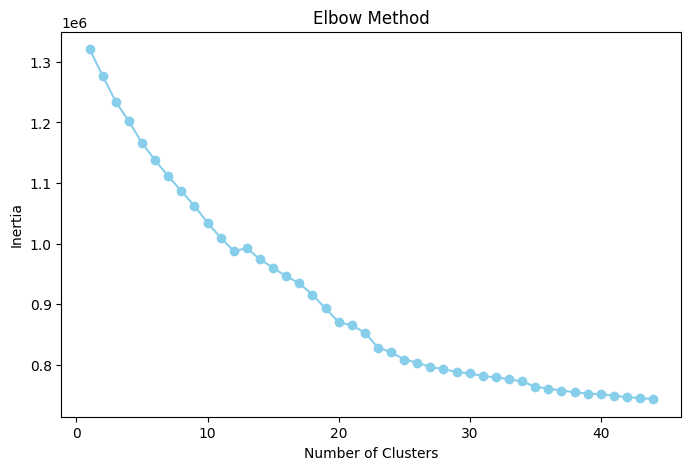

In [25]:
import matplotlib.pyplot as plt
inertia = []
for i in range(1, 45):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(final_movie_data_scaled[features])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 45), inertia, marker='o', color='skyblue')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [26]:
# Using KMeans clustering
# Define the model
kmeans = KMeans(n_clusters=23, random_state=0)

# Fit the model
kmeans.fit(final_movie_data_scaled[features])


KMeans(n_clusters=23, random_state=0)

In [27]:
hierarchical = AgglomerativeClustering(n_clusters=23)
hierarchical.fit(final_movie_data_scaled[features])

AgglomerativeClustering(n_clusters=23)

In [28]:
# Using DBSCAN clustering
# Define the model
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan.fit(final_movie_data_scaled[features])

DBSCAN(min_samples=2)

In [ ]:


# Evaluate the clustering results
db_kmeans = davies_bouldin_score(final_movie_data_scaled[features], kmeans.labels_)
db_hierarchical = davies_bouldin_score(final_movie_data_scaled[features], hierarchical.labels_)
db_dbscan = davies_bouldin_score(final_movie_data_scaled[features], dbscan.labels_)
db_spectral = davies_bouldin_score(final_movie_data_scaled[features], spectral.labels_)

print(f"Davies-Bouldin Index for KMeans: {db_kmeans}")
print(f"Davies-Bouldin Index for Hierarchical Clustering: {db_hierarchical}")
print(f"Davies-Bouldin Index for DBSCAN: {db_dbscan}")
print(f"Davies-Bouldin Index for Spectral Clustering: {db_spectral}")

Davies-Bouldin Index for KMeans: 2.32675804100351
Davies-Bouldin Index for Hierarchical Clustering: 2.2559278065548507
Davies-Bouldin Index for DBSCAN: 1.3589587380356345


In [30]:
# Getting the number of elements in each cluster
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)
print(len(cluster_counts))

5     3405
6     2833
2     2293
21    1822
11    1758
3     1755
18    1708
7     1625
4     1224
1     1168
19    1020
12     999
16     831
20     759
14     632
17     445
0      367
13     337
10     263
22     209
8      192
15     191
9       65
Name: count, dtype: int64
23


In [31]:
# Add the preferred cluster labels to the final_movie_data dataframe
final_movie_data['cluster'] = kmeans.labels_

# Find closest movies

In [32]:
# Cosine similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


def closest_by_cosine(data, target_point, n_neighbors=5):
    data_array = data.values  # Convert DataFrame to NumPy array
    similarities = cosine_similarity(data_array, target_point.reshape(1, -1)).flatten()
    closest_indices = np.argsort(similarities)[-n_neighbors:][::-1]  # Sort by descending similarity
    return data.iloc[closest_indices], similarities[closest_indices]  # Use .iloc to return DataFrame rows

# KD-Tree
def closest_with_kdtree(data, target_point, n_neighbors=5):
    data_array = data.values  # Convert DataFrame to NumPy array
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(data_array)
    distances, indices = nbrs.kneighbors(target_point.reshape(1, -1))
    return data.iloc[indices[0]], distances[0]  # Use .iloc for rows

# Euclidean Distance
def closest_by_euclidean(data, target_point, n_neighbors=5):
    data_array = data.values  # Convert DataFrame to NumPy array
    distances = np.linalg.norm(data_array - target_point, axis=1)
    closest_indices = np.argsort(distances)[:n_neighbors]  # Sort by ascending distance
    return data.iloc[closest_indices], distances[closest_indices]  # Use .iloc for rows

In [33]:
movie_id = 2
cluster_recommendation = (final_movie_data.loc[final_movie_data['movieId'] == movie_id, 'cluster'].values)[0]

In [34]:
movies_cluster = final_movie_data.loc[(final_movie_data['cluster'] == cluster_recommendation) & (final_movie_data['movieId'] != 2), features]
rec_movie = final_movie_data.loc[final_movie_data['movieId'] == movie_id, features].values.flatten()

points, dist = closest_by_cosine(movies_cluster, rec_movie)
print(points.index)

points, dist = closest_with_kdtree(movies_cluster, rec_movie)
print(points.index)

points, dist = closest_by_euclidean(movies_cluster, rec_movie)
print(points.index)


Index([982, 985, 576, 1862, 1929], dtype='int64')
Index([576, 2185, 574, 1462, 1925], dtype='int64')
Index([576, 2185, 574, 1462, 1925], dtype='int64')


In [35]:

movieIds = final_movie_data.loc[points.index]["movieId"].values

movie_titles = movie_titles[movie_titles['movieId'].isin(movieIds)]["title"]
print(movie_titles)

579              Home Alone (1990)
581                 Aladdin (1992)
1493               Hercules (1997)
1968    Little Mermaid, The (1989)
2238          Bug's Life, A (1998)
Name: title, dtype: object
